<a href="https://colab.research.google.com/github/puneet-08/projects/blob/main/Image_Captioning_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with Attention


In this notebook we are going to implement image captioning with visual attention. 

**Goal** - Given an input image and our model has to generate a 'caption' for it.

In [1]:
#Importing the libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, Bidirectional, TimeDistributed,InputLayer, Lambda, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization, Dropout,Concatenate, AdditiveAttention
import time
import os
import json, collections, random
from PIL import Image

**Dataset**

For this task we are going to use [MS-COCO](https://cocodataset.org/#home) dataset. This data set contains 82783 images, each of the image has approximately 5 distinct captions. Let's download this dataset -

In [2]:
# Downloading caption annotation files
annotation_folder = '/annotations/'

if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)


# Downloading image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 279s 0us/step


In [3]:
#Loading captions
annotation_file = '/content/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
  annotations = json.load(f)

In [4]:
#Number of images
len(annotations['images'])

82783

In [5]:
#Number of captions
len(annotations['annotations'])

414113

In [6]:
#Checking a few of the images

annotations['images'][:5]

[{'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
  'date_captured': '2013-11-14 16:28:13',
  'file_name': 'COCO_train2014_000000057870.jpg',
  'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
  'height': 480,
  'id': 57870,
  'license': 5,
  'width': 640},
 {'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
  'date_captured': '2013-11-14 16:29:45',
  'file_name': 'COCO_train2014_000000384029.jpg',
  'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
  'height': 429,
  'id': 384029,
  'license': 5,
  'width': 640},
 {'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000222016.jpg',
  'date_captured': '2013-11-14 16:37:59',
  'file_name': 'COCO_train2014_000000222016.jpg',
  'flickr_url': 'http://farm2.staticflickr.com/1431/1118526611_09172475e5_z.jpg',
  'height': 640,
  'id': 222016,
  'license': 1,
  'width': 480},
 {'coco_url': 

In [7]:
#Checking a few of the captions

annotations['annotations'][:5]

[{'caption': 'A very clean and well decorated empty bathroom',
  'id': 48,
  'image_id': 318556},
 {'caption': 'A panoramic view of a kitchen and all of its appliances.',
  'id': 67,
  'image_id': 116100},
 {'caption': 'A blue and white bathroom with butterfly themed wall tiles.',
  'id': 126,
  'image_id': 318556},
 {'caption': 'A panoramic photo of a kitchen and dining room',
  'id': 148,
  'image_id': 116100},
 {'caption': 'A graffiti-ed stop sign across the street from a red car ',
  'id': 173,
  'image_id': 379340}]

In [8]:
#Printing all of the multiple captions for one random image_id

for i in range(len(annotations['annotations'])):
  if annotations['annotations'][i]['image_id'] == 318556 :
    print(annotations['annotations'][i])

{'image_id': 318556, 'id': 48, 'caption': 'A very clean and well decorated empty bathroom'}
{'image_id': 318556, 'id': 126, 'caption': 'A blue and white bathroom with butterfly themed wall tiles.'}
{'image_id': 318556, 'id': 219, 'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.'}
{'image_id': 318556, 'id': 255, 'caption': 'An angled view of a beautifully decorated bathroom.'}
{'image_id': 318556, 'id': 3555, 'caption': 'A clock that blends in with the wall hangs in a bathroom. '}


### Data Preprocessing


There are quite a few data processing steps we need to take, some of them for images other for captions/text. I am going to seperate these into **four phases**. In the begining of each phase I am going to discuss all the steps we need to undertake.

**Phase 1**

Steps to follow - 
1. Append sos and eos tokens for each of the captions.
2. Grouping multiple captions for each of the distinct image.
3. Generating a training dataset consisting of one image urls and one corresponding caption. This training dataset can contain multiple copies of the same image. One for each of the multiple associated captions.



We can see there are multiple captions for the same image linked by the distinct image id for each image. Now we need to group all the captions for a single image. Also we are going to append **\<sos>** token at the starting and **\<eos>** token at the end of each caption sentence, where -
*   **\<sos>** means start of sentence
*   **\<eos>** means end of sentence

In [9]:
#Step 1 and Step 2
#Grouping all captions together having the same image ID

image_path_to_caption = collections.defaultdict(list)
for cap in annotations['annotations']:
  caption = f"<sos> {cap['caption']} <eos>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (cap['image_id']) #creating url image path of images from caption image_id
  image_path_to_caption[image_path].append(caption)

We have approximately 82000 images. Out of these we are going to use 6000 images for training. Each of the image has 5 captions; so our training data will contain 30000 captions in addition to 6000 images.

In [10]:
image_paths = list(image_path_to_caption.keys())

#Shuffling Images
random.shuffle(image_paths)

#Selecting the first 6000 image_paths from the shuffled set
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [11]:
#Step 3

train_captions = []
image_paths = []

for image in train_image_paths:
  captions = image_path_to_caption[image]
  train_captions.extend(captions)
  image_paths.extend([image]*len(captions)) #making multiple copies of each image url for each image caption, i.e. one url for one caption

<sos> A man on the beach playing with a yellow Frisbee.  <eos>


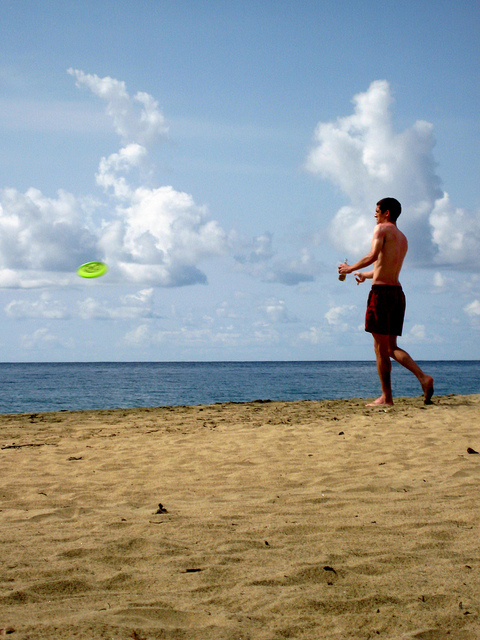

In [12]:
#Printing a random image and associated caption
print(train_captions[1635])
Image.open(image_paths[1635])

**Phase 2**

In this phase we are going to preprocess the image to make it suitable for the model. Steps to follow - 
1. Resize the image to 299 x 299.
2. Preprocess the images using preprocess_input method of InceptionV3 model architecture (pretrained on Imagenet). This method normalizes the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.
3. Create an image feature extractor using output of last convolutional layer of Inception v3 architecture.
4. Extract relevant information for all of the training images using 'image feature extractor'.

In [13]:
#Step 1 and Step 2
#Writing a function to generate resized image preprocessed for inception_v3 
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.io.decode_jpeg(img, channels = 3)
  img = tf.keras.layers.Resizing(299,299)(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path


Let's initialize InceptionV3 model, pretrained on imagenet. We are going to input our resized image which is preprocessed for this architecture and take the output from the last convolutional layer. We are going to name this as 'image_feature_extractor'.  This image_feature_extractor vector captures all the information of the features of the image. Later on we are going to send this vector to our model.

In [14]:
#Step 3
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
input = image_model.input
output = image_model.layers[-1].output

image_features_extractor = Model(input, output)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
image_features_extractor.summary()

Use image_feature_extractor to extract all the necessary information for each of the unique image in the training dataset.

In [16]:
#Step 4
import tqdm as tqdm
encode_train = sorted(set(image_paths)) #extracting unique urls of images

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train) #creating dataset of the urls
image_dataset = image_dataset.map(load_image, num_parallel_calls = tf.data.AUTOTUNE).batch(16) #preprocessing dataset using load_image function

batch_features_path_dict = {}

for img, path in tqdm.tqdm(image_dataset): #preprocessing our dataset using image_feature_extractor
  batch_features_ = image_features_extractor(img) #shape(batch_size, 8, 8, 2048)
  batch_features_ = tf.reshape(batch_features_, (batch_features_.shape[0], -1, batch_features_.shape[-1])) #shape (batch_size, 64, 2048)
  for bf, path_ in zip(batch_features_, path):
    path_of_feature = path_.numpy().decode("utf-8")
    batch_features_path_dict[path_.numpy().decode('utf-8')] = bf.numpy()
    np.save(path_of_feature, bf.numpy())
    

100%|██████████| 375/375 [01:43<00:00,  3.62it/s]


In [17]:
len(batch_features_path_dict)

6000

**Phase 3**

Tokenize the captions and convert them to vectors. 

In [18]:
vocab_size = 5000
max_len = 50

tokenizer = TextVectorization(max_tokens = vocab_size, output_mode='int', output_sequence_length=max_len)
tokenizer.adapt(train_captions)

captions_int_to_word = {k:v for k,v in enumerate(tokenizer.get_vocabulary())} #dictionary mapping integers to words
captions_word_to_int = {v:k for k,v in enumerate(tokenizer.get_vocabulary())} #dictionary mapping words to integers

In [19]:
captions_vector = tokenizer(train_captions)

**Phase 4**

In this phase have to tie together the features extracted in phase 2 and the tokenized caption vectors created in phase 3. These both are further used to create training and validation datasets where -
*  X -> image features(input features)
*  y -> caption vectors (target features)

Steps to follow - 

1. Create a dictionary with keys as images and corresponding values as list of all the caption vectors for the particular image.
2. Use this dictionary to create lists of training and validation sets.
3. Create a batched dataset of image features and corresponding caption vectors.

In [20]:
len(train_image_paths), len(image_path_to_caption), len(image_paths), len(train_captions), captions_vector.shape

(6000, 82783, 30009, 30009, TensorShape([30009, 50]))

In [21]:
#Step 1
img_to_cap_vector = collections.defaultdict(list)

for img, cap in zip(image_paths, captions_vector): 
  img_to_cap_vector[img].append(cap)

In [22]:
#Step 2
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys) 

slice_index = int(len(img_keys) * 0.8) 
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:] 

In [23]:
#Creating training lists of image url and corresponding caption vectors

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_train[:10], cap_train[:10]

(['/content/train2014/COCO_train2014_000000542488.jpg',
  '/content/train2014/COCO_train2014_000000542488.jpg',
  '/content/train2014/COCO_train2014_000000542488.jpg',
  '/content/train2014/COCO_train2014_000000542488.jpg',
  '/content/train2014/COCO_train2014_000000542488.jpg',
  '/content/train2014/COCO_train2014_000000128106.jpg',
  '/content/train2014/COCO_train2014_000000128106.jpg',
  '/content/train2014/COCO_train2014_000000128106.jpg',
  '/content/train2014/COCO_train2014_000000128106.jpg',
  '/content/train2014/COCO_train2014_000000128106.jpg'],
 [<tf.Tensor: shape=(50,), dtype=int64, numpy=
  array([   3,    2, 3202,  447,  159,   88,   32,    5,    7,  178,    4,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0])>,
  <tf.Tensor: shape=(50,), dtype=int64, nump

In [24]:
#Creating validation lists of image url, corresponding caption vectors and corresponding captions text 

img_name_val = []
cap_val = []
captions_val_text = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])
  captions_val_text.extend(image_path_to_caption[imgv])

img_name_val[:10], cap_val[:10], captions_val_text[:10]

(['/content/train2014/COCO_train2014_000000343183.jpg',
  '/content/train2014/COCO_train2014_000000343183.jpg',
  '/content/train2014/COCO_train2014_000000343183.jpg',
  '/content/train2014/COCO_train2014_000000343183.jpg',
  '/content/train2014/COCO_train2014_000000343183.jpg',
  '/content/train2014/COCO_train2014_000000427150.jpg',
  '/content/train2014/COCO_train2014_000000427150.jpg',
  '/content/train2014/COCO_train2014_000000427150.jpg',
  '/content/train2014/COCO_train2014_000000427150.jpg',
  '/content/train2014/COCO_train2014_000000427150.jpg'],
 [<tf.Tensor: shape=(50,), dtype=int64, numpy=
  array([   3,  281,  186,    9,  300,   79,   91,  436,   10,  421,  318,
         1209,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0])>,
  <tf.Tensor: shape=(50,), dtype=int64, nump

In [25]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24006, 24006, 6003, 6003)

Next we are going to create a dataset with image features extracted using inceptionV3 module and corresponding captions vectors using tokenizers.

In [26]:
#Step 3

batch_size = 64
buffer_size = 1000
num_steps = len(img_name_train) // batch_size

# Shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [27]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [29]:
# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(buffer_size).batch(batch_size)

### Model Architecture

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/abs/1502.03044) paper. Our Image captioning model has three parts -

1. **Encoder** - Encoder is based on Convolutional Neural Network architecture. It encodes an image into a vector which contains all the information of the image. It takes in an input vector of shape (batch_size, 64, 2048) which is processed to an output vector of shape (batch_size, 64, embedding_dimension).

2. **Attention** - Attention vector provides the context to the decoder. Task of the attention unit is to help decoder in attending most important parts of the image. These parts can be called as context. The context helps decoder to attend to the most useful parts of image while generating the captions. 

>There are many Attention architectures but we are going to employ [Bahdanau’s attention](https://arxiv.org/pdf/1409.0473.pdf) in this notebook.

3. **Decoder** - It employs Recurrent Neural Networks. Decoder usually takes in the output of encoder and an attention vector/context vector as inputs and tries to encapsulate different parts of images into words at each time step of the RNN unit. We are going to use single layer of  Gated Recurrent Unit (GRU) in the model. The output of GRU will be passed to two Dense layers to output tensors of shape (batch_size, embedding_dimension).

This model is similar to the one we used in the Machine translation.

Shapes of different tensors through the model stacks will be higlighted in the code.

In [30]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self, embedding_dim):
    super(CNN_Encoder, self).__init__()
    self.fc = Dense(embedding_dim) 

  def call(self, x): #input=shape of x - (batch_size, 64, 2048)
    x = self.fc(x) 
    x = tf.nn.relu(x) #output-shape (batch_size, 64, emb_dim)
    return x

In [31]:
#Testing Encoder stack

x = tf.ones((16,64,2408))
encoder = CNN_Encoder(256)
values = encoder(x)
print ('Encoder ouput shape: {}'.format(encoder(x).shape))

Encoder ouput shape: (16, 64, 256)


In [32]:
class Attention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, query, values):
     # values (CNN_encoder output) shape == (batch_size, 64, embedding_dim)
     # query (decoder output) shape == (batch_size, latent_state)
     hidden_with_time_axis = tf.expand_dims(query, 1) #reshaped to (batch_size, 1, latent_state)
     score = self.V(tf.nn.tanh(self.W1(hidden_with_time_axis)+self.W2(values))) #shape == (batch_size, 64, 1)
     attention_weights = tf.nn.softmax(score, axis=1) #attention_weights shape == (batch_size, 64, 1)

     context_vector = attention_weights * values #shape == (batch_size, 64, embedding_dim)
     context_vector = tf.reduce_sum(context_vector, axis = 1) #shape == (batch_size,embedding_dim)

     return context_vector, attention_weights

In [33]:
#Testing Attention stack

query = tf.ones((16, 128))
attention = Attention(10)
context_vec, attn_weights = attention(query, values)

print('Context vector shape: {}'.format(context_vec.shape))
print('Attention weights shape: {}'.format(attn_weights.shape))

Context vector shape: (16, 256)
Attention weights shape: (16, 64, 1)


In [34]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.gru = GRU(self.units, return_state = True, return_sequences = True, recurrent_initializer= 'glorot_uniform')
    self.fc1 = Dense(self.units)
    self.fc2 = Dense(vocab_size)
    self.attention = Attention(self.units)

  def call(self, x, query, values):
    context_vector, attention_weights = self.attention(query, values)
    x = self.embedding(x) #shape == (batch_size,1, emb_dim)
    x = tf.concat([tf.expand_dims(context_vector, axis = 1),x], axis =-1) #shape ==(batch_size, 1, emb_dim + hidden_dim)
    output, state = self.gru(x) #output_shape ==(batch_size, 1, hidden_units), state == (batch_size, hidden_units)
    x = self.fc1(output) #shape = (batch_size, 1, units)
    x = tf.reshape(x, (x.shape[0], x.shape[-1])) #shape == (batch_size, units)
    x = self.fc2(x) #shape == (batch_size, vocab_size)
    return x, state, attention_weights #attn_weights shape == (batch_size, 64, 1)
  
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [35]:
#Testing Decoder stack

x = tf.ones((16,1))
decoder = RNN_Decoder(300, 512, 5000)
x, state, attention_weights = decoder(x, query, values)


print ('Decoder ouput shape: {}'.format(x.shape))
print ('Decoder state shape: {}'.format(state.shape))
print ('Attention_weights shape: {}'.format(attention_weights.shape))

Decoder ouput shape: (16, 5000)
Decoder state shape: (16, 512)
Attention_weights shape: (16, 64, 1)


### Training the Model

**Defining the Loss Function**

As our captions are padded with tokens; we need to ensure that while calcuating the loss, our model ignores all the predictions for the masked tokens. Therefore we are going to write a custom loss function which is similar to cross entropy but in addition ignores the tokens defined by masks.

In [36]:
optimizer = Adam() #using Adam optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = real != 0
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

**Checkpoints**

In [37]:
checkpoint_path = os.path.abspath('.')
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [38]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

**Initializing Model Hyperparameters**

In [39]:
#Model Hyperparamets

embedding_dim = 256
units = 512
vocab_size = 5000

**Initializing Model Stacks**

In [40]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

**Model Training Methodology**

Steps to take - 

1. Input preprocessed image vector stored in .npy file to the encoder.
2. Input 3 vectors to decoder -
>* Output of encoder named as 'values' vector.
>* Decoder initial state is initialized to zeros. This is passed in as 'query' vector.
>* First token of the vectorized captions sentence, i.e. **\<sos>**
3. The decoder uses attention layer to output - predictions vector (next word prediction for the caption), query vector(new hidden state) and attention weights.
4. Now we compute loss between the 'predictions vector' and the 'next token in the caption sentence'. Aim is to minimize this loss so that over time so that the model can output the correct next word for the caption.
5. Regardless of what model predicts, at next training step, we input the next token in the captions to the decoder. This is called teacher forcing. 
Teacher forcing is the technique where the target word is passed as the next input to the decoder.
6. This is repeated until **\<eos>** is input to decoder. This token helps decoder to learn to stop predicting further.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

Let's code this now -

In [41]:
@tf.function

def train_step(image_tensor, target):
  loss = 0

  query = decoder.reset_state(batch_size=target.shape[0])

  with tf.GradientTape() as tape:
    values = encoder(image_tensor)

    for i in range(0, target.shape[-1]-1):
      dec_input = tf.expand_dims(target[:,i],axis =-1)
      predictions, query, _ = decoder(dec_input,query,values)
      loss += loss_function(target[:,i+1], predictions)

  total_loss = (loss/int(target.shape[-1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [42]:
#Training for a few epochs and calculating loss.

loss_plot = []

EPOCHS = 30

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    
    loss_plot.append(total_loss / num_steps) # storing the epoch end loss value to plot later

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.8964
Epoch 1 Batch 100 Loss 1.0971
Epoch 1 Batch 200 Loss 0.9290
Epoch 1 Batch 300 Loss 0.8417
Epoch 1 Loss 1.006389
Time taken for 1 epoch 315.36 sec

Epoch 2 Batch 0 Loss 0.8338
Epoch 2 Batch 100 Loss 0.8971
Epoch 2 Batch 200 Loss 0.7603
Epoch 2 Batch 300 Loss 0.6829
Epoch 2 Loss 0.762693
Time taken for 1 epoch 179.80 sec

Epoch 3 Batch 0 Loss 0.7412
Epoch 3 Batch 100 Loss 0.7094
Epoch 3 Batch 200 Loss 0.6681
Epoch 3 Batch 300 Loss 0.5923
Epoch 3 Loss 0.689194
Time taken for 1 epoch 178.94 sec

Epoch 4 Batch 0 Loss 0.6890
Epoch 4 Batch 100 Loss 0.6588
Epoch 4 Batch 200 Loss 0.6476
Epoch 4 Batch 300 Loss 0.6000
Epoch 4 Loss 0.641459
Time taken for 1 epoch 178.69 sec

Epoch 5 Batch 0 Loss 0.6696
Epoch 5 Batch 100 Loss 0.6327
Epoch 5 Batch 200 Loss 0.5896
Epoch 5 Batch 300 Loss 0.6275
Epoch 5 Loss 0.603658
Time taken for 1 epoch 174.01 sec

Epoch 6 Batch 0 Loss 0.6030
Epoch 6 Batch 100 Loss 0.5856
Epoch 6 Batch 200 Loss 0.5990
Epoch 6 Batch 300 Loss 0.5642
Epoch 6

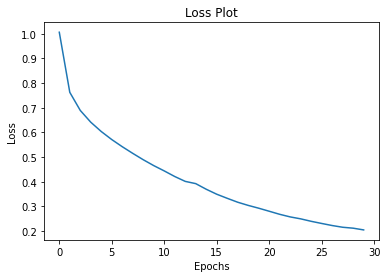

In [43]:
#Plotting Loss

import matplotlib.pyplot as plt
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Generating Captions

During prediction, instead of using teacher-forcing; at time-step 't' we input the word predicted at time-step 't-1'. We keep on repeating this until the model predicts **\<eos>** or we reach a predefined maximum length for the generated caption.

Lets code this now and predict captions for some images.

In [44]:
def cap_generator(image_path):
  caption = 'sos'
  attention_plot = np.zeros((max_len, attention_features_shape))
  query = decoder.reset_state(batch_size=1)
  img, img_path = load_image(image_path)
  img_tensor = image_features_extractor(tf.expand_dims(img,0))
  img_tensor = tf.reshape(img_tensor, (1,-1, img_tensor.shape[-1]))
  values = encoder(img_tensor)

  dec_input = tf.expand_dims([captions_word_to_int['sos']],0)

  for i in range(50):
    pred, query, attention_weights = decoder(dec_input, query, values)
    attention_plot[i] = tf.reshape(attention_weights, (1,attention_features_shape)).numpy()
    dec_input = tf.expand_dims([np.argmax(pred)],0)
    caption = caption + " " + captions_int_to_word[np.argmax(pred)]
    if captions_int_to_word[np.argmax(pred)] == 'eos':
      break
  leng_ = caption.split()
  attention_plot = attention_plot[:len(leng_)-1,:]
  return attention_plot, caption


**Attention Weights Plot**

Before testing our model we also need to implement a function to visualize attention weights, just to know part in the image our model is focusing while generating a particular word in the caption.

In [45]:
def plot_attention(image, result, attention_plot):
    
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(20, 20))
    caption = result.split()[1:]
    len_result = len(caption)

    for i in range(len_result):
        temp_att = np.resize(attention_plot[i,:], (8, 8))
        grid_size = max(int(np.ceil(len_result/3)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(caption[i])
        img = plt.imshow(temp_image)
        plt.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
        plt.axis('Off')

    plt.tight_layout()
    plt.show()

**Generating Captions and Attention Plots for Random Images**

5651
Real Caption : <sos> A plate that has some chicken and vegetables on it. <eos>
Gen Caption  : sos a plate sitting on a table next to some wine sitting on a table eos


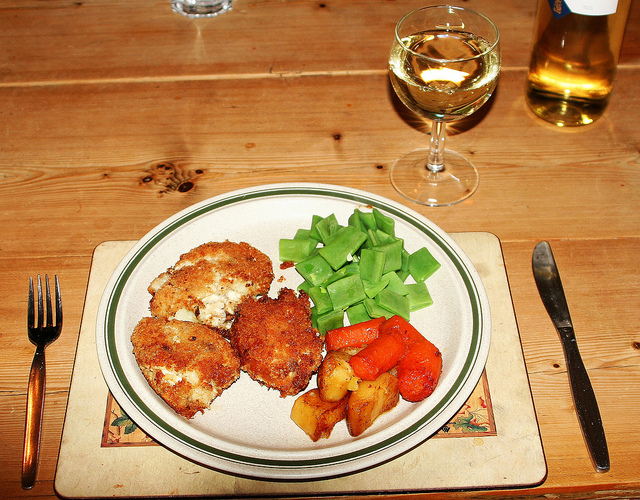

In [62]:
rand_img =np.random.randint(0, len(img_name_val))
print(rand_img)
attention_plot, caption = cap_generator(img_name_val[rand_img])
print('Real Caption :', captions_val_text[rand_img])
print('Gen Caption  :', caption)

Image.open(img_name_val[rand_img])

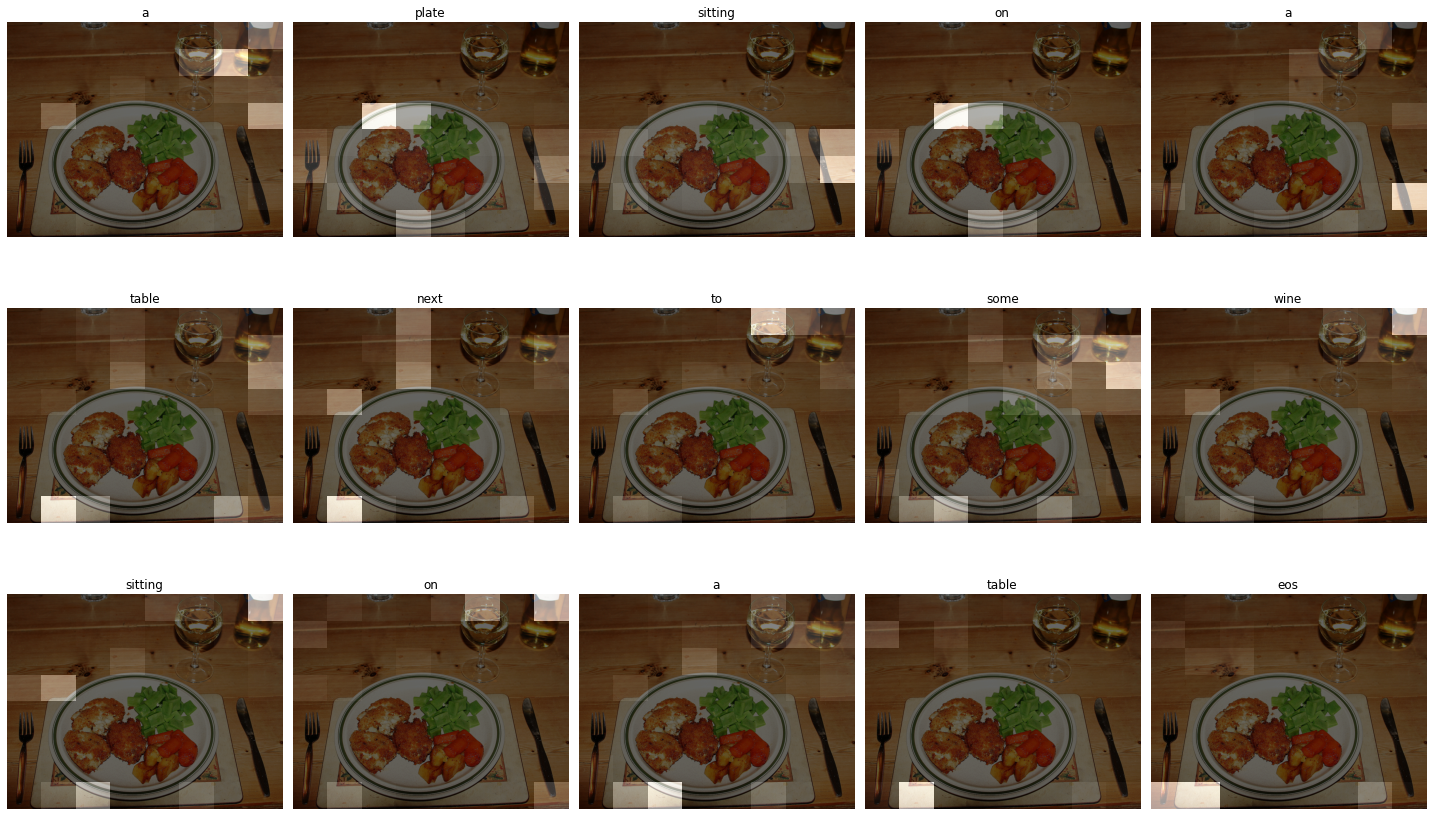

In [63]:
plot_attention(img_name_val[rand_img], caption, attention_plot)

Visualizing a few more...

1661
Real Caption : <sos> a couple of people that are standing on a baseball field <eos>
Gen Caption  : sos a baseball player is ready to hit the ball eos


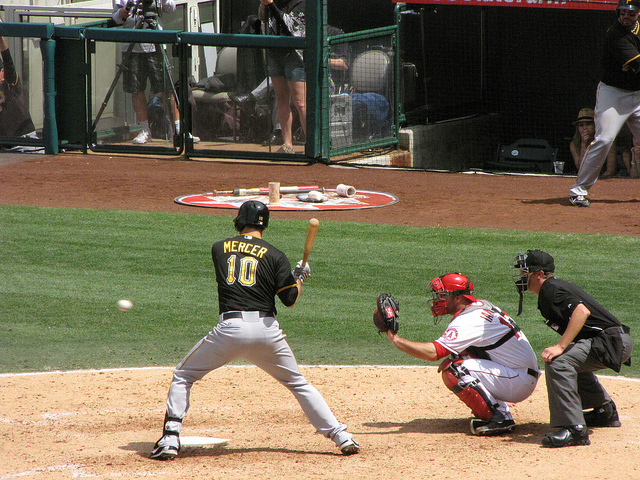

In [64]:
rand_img =np.random.randint(0, len(img_name_val))
print(rand_img)
attention_plot, caption = cap_generator(img_name_val[rand_img])
print('Real Caption :', captions_val_text[rand_img])
print('Gen Caption  :', caption)

Image.open(img_name_val[rand_img])

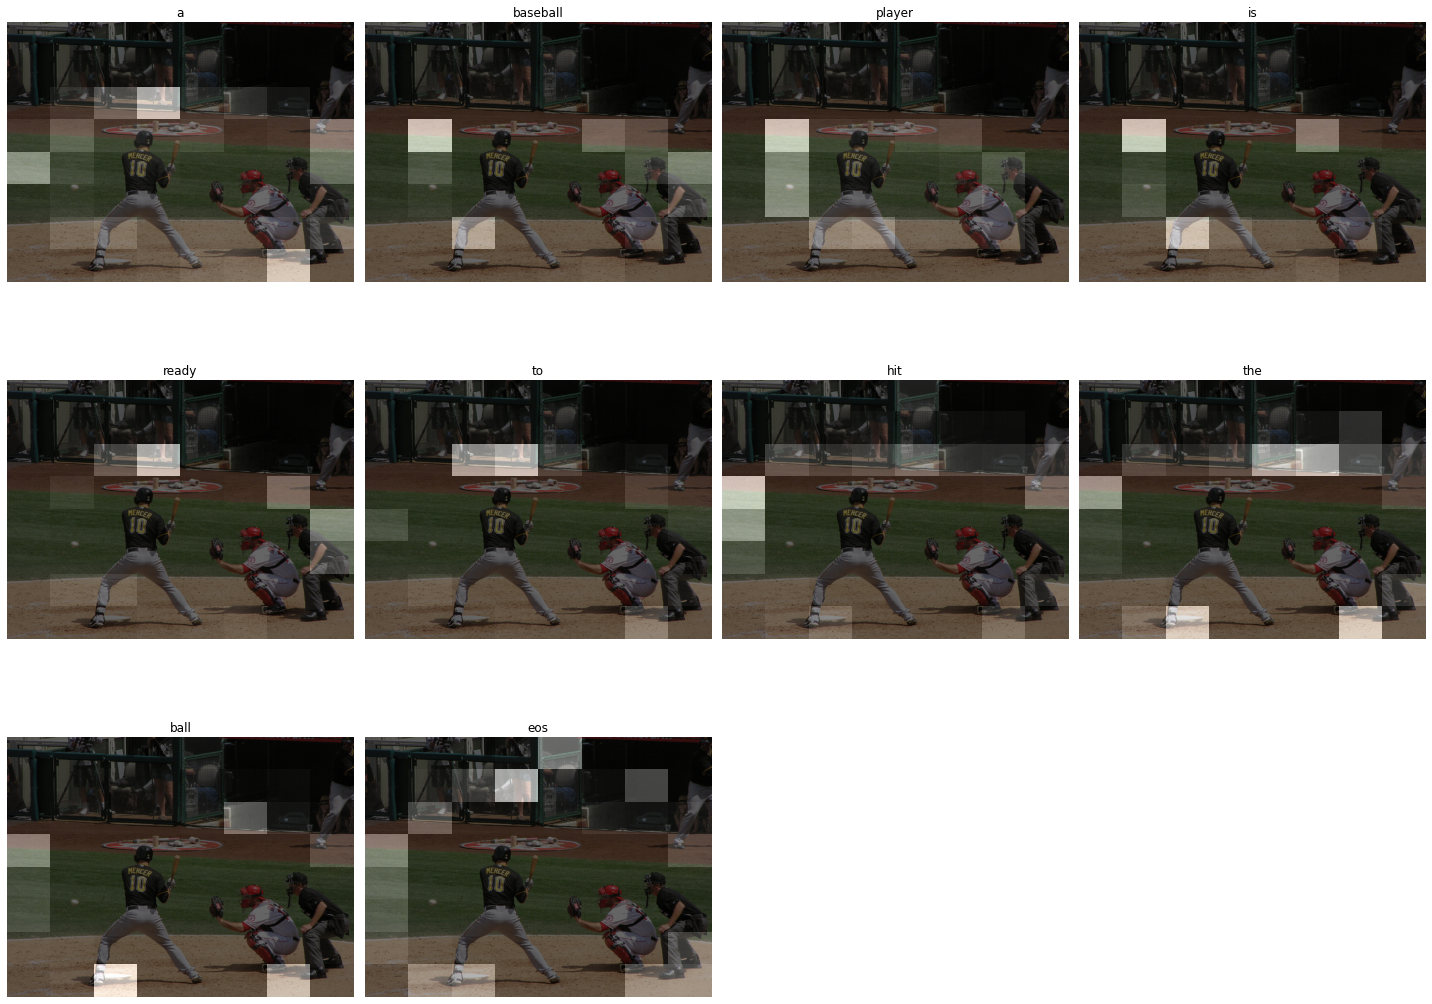

In [65]:
plot_attention(img_name_val[rand_img], caption, attention_plot)

2098
Real Caption : <sos> A red double decker bus parked at the curb waiting for passengers. <eos>
Gen Caption  : sos a large red and blue double decker bus is driving down a road eos


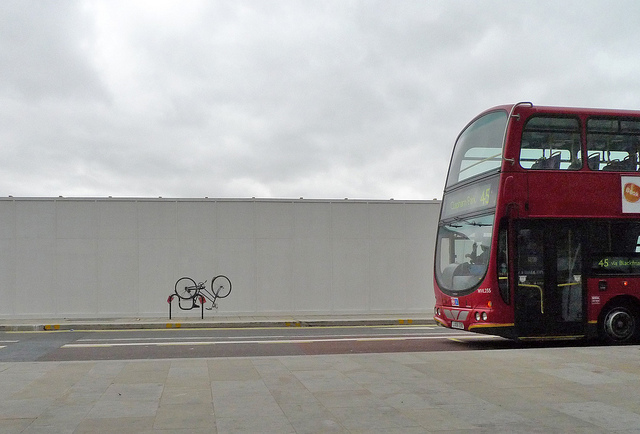

In [91]:
rand_img =np.random.randint(0, len(img_name_val))
print(rand_img)
attention_plot, caption = cap_generator(img_name_val[rand_img])
print('Real Caption :', captions_val_text[rand_img])
print('Gen Caption  :', caption)

Image.open(img_name_val[rand_img])

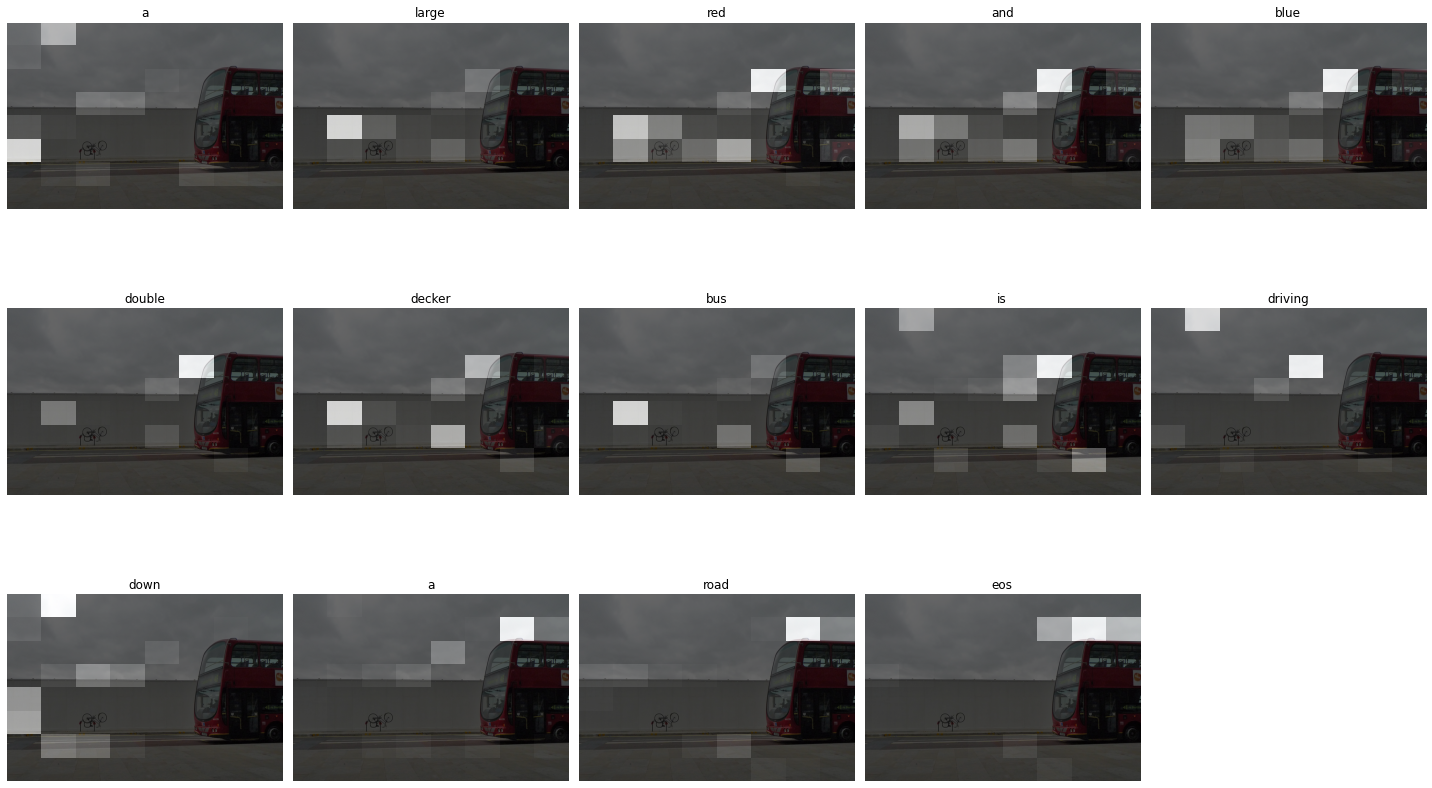

In [92]:
plot_attention(img_name_val[rand_img], caption, attention_plot)

The model does give some good results and also some wierd results. It can surely be improved by training for more epochs on a larger dataset.

### References

1. https://www.youtube.com/watch?v=YAgjfMR9R_M&list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r&index=13
2. https://www.tensorflow.org/tutorials/text/image_captioning
3. https://arxiv.org/abs/1502.03044